# hw2: Single-shot Multibox Object Detection
2018131605 원종빈

In [16]:
# !git clone https://github.com/MLman/d2l-pytorch.git

%matplotlib inline
import sys, os
sys.path.insert(0, './d2l-pytorch/')
import d2l
from d2l.ssd_utils import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import json
import time
from tqdm import tqdm
from PIL import Image

In [4]:
def cls_predictor(input_channels, num_anchors, num_classes):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

In [5]:
def bbox_predictor(input_channels, num_anchors):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * 4, kernel_size=3, padding=1)

In [6]:
def forward(x, block):
    return block(x)
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [7]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0,2,3,1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [8]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels

    blk.append(nn.MaxPool2d(2, 2))
    return nn.Sequential(*blk)

forward(torch.zeros((2,3,20,20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [9]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters)-1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2,3,256,256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [10]:
## Complete model
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveAvgPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk


def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = create_anchors((Y.size(2),), (256/Y.size(2),), size)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [11]:
import itertools, math

def create_anchors(feature_map_sizes, steps, sizes):
    scale = 256.
    steps = [s / scale for s in steps]
    sizes = [s / scale for s in sizes]
    
    aspect_ratios = ((2,),)  ## why use tuple in tuple? for multiple aspect_ratios?
    
    num_layers = len(feature_map_sizes)
    boxes = []
    for i in range(num_layers):
        fmsize = feature_map_sizes[i]
        for h, w in itertools.product(range(fmsize), repeat=2):
            cx = (w + 0.5) * steps[i]
            cy = (h + 0.5) * steps[i]
            s = sizes[i]
            boxes.append((cx, cy, s, s))
            
            s = sizes[i+1]
            boxes.append((cx, cy, s, s))
            
            for ar in aspect_ratios[i]:
                boxes.append((cx, cy, (s * math.sqrt(ar)), (s / math.sqrt(ar))))
                boxes.append((cx, cy, (s / math.sqrt(ar)), (s * math.sqrt(ar))))
    
    return torch.Tensor(boxes)


In [12]:
sizes = [[0.2*256, 0.272*256], [0.37*256, 0.447*256], [0.54*256, 0.619*256],
         [0.71*256, 0.79*256], [0.88*256, 0.961*256]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [13]:
## Define TinySSD
class TinySSD(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        input_channels_cls = 128
        input_channels_bbox = 128
        self.num_classes = num_classes
        
        self.blk = []
        self.cls = []
        self.bbox = []
        
        self.blk_0 = get_blk(0)
        self.blk_1 = get_blk(1)
        self.blk_2 = get_blk(2)
        self.blk_3 = get_blk(3)
        self.blk_4 = get_blk(4)
        
        self.cls_0 = cls_predictor(64, num_anchors, num_classes)
        self.cls_1 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_2 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_3 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_4 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        
        self.bbox_0 = bbox_predictor(64, num_anchors)
        self.bbox_1 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_2 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_3 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_4 = bbox_predictor(input_channels_bbox, num_anchors)
        
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        
        X, anchors[0], cls_preds[0], bbox_preds[0] = blk_forward(X, self.blk_0, sizes[0], ratios[0], self.cls_0, self.bbox_0)
        X, anchors[1], cls_preds[1], bbox_preds[1] = blk_forward(X, self.blk_1, sizes[1], ratios[1], self.cls_1, self.bbox_1)
        X, anchors[2], cls_preds[2], bbox_preds[2] = blk_forward(X, self.blk_2, sizes[2], ratios[2], self.cls_2, self.bbox_2)
        X, anchors[3], cls_preds[3], bbox_preds[3] = blk_forward(X, self.blk_3, sizes[3], ratios[3], self.cls_3, self.bbox_3)
        X, anchors[4], cls_preds[4], bbox_preds[4] = blk_forward(X, self.blk_4, sizes[4], ratios[4], self.cls_4, self.bbox_4)
        
        return (torch.cat(anchors, dim=0), concat_preds(cls_preds).reshape((-1, 5444, self.num_classes + 1)), concat_preds(bbox_preds))
        
    
    
        

In [14]:
anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
    
net = TinySSD(3, num_classes=1)
net.apply(init_weights)

X = torch.zeros((32,3,256,256))
anchors, cls_preds, bbox_preds = net(X)

anchors.shape, cls_preds.shape, bbox_preds.shape

(torch.Size([5444, 4]), torch.Size([32, 5444, 2]), torch.Size([32, 21776]))

## Training

In [19]:
batch_size = 32
data_dir = os.path.join('d2l-pytorch', 'data', 'pikachu')
train_dataset = PIKACHU(data_dir, 'train')
val_dataset = PIKACHU(data_dir, 'val')

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=4)

In [20]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### Define Loss & Evaluation Functions

In [21]:
id_cat = dict()
id_cat[0] = 'pikachu'

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, device='cuda:0', eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        self.eps = eps
        
    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = -1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

class SSDLoss(nn.Module):
    def __init__(self, loc_factor, jaccard_overlap, device='cuda:0', **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.device = device
        
    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]
    
    def loc_transformation(x, anchors, overlap_indicies):
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                    (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                    torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                    torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                    ], dim=1)
        
    def forward(self, class_hat, bb_hat, class_true, bb_true, anchors):        
        loc_loss = 0.0
        class_loss = 0.0
    
        
        for i in range(len(class_true)):  # Batch level

            class_hat_i = class_hat[i, :, :]

            bb_true_i = bb_true[i].float()
            
            class_true_i = class_true[i]            
            
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(self.device)
            
            overlap_list = d2l.find_overlap(bb_true_i.squeeze(0), anchors, self.jaccard_overlap)
            
            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j].long()

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(self.device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

## Train Model

AssertionError: Torch not compiled with CUDA enabled

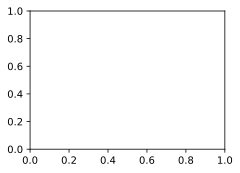

In [22]:
loss = SSDLoss(loc_factor=5.0, jaccard_overlap=0.5, device="cuda:0")

num_epochs = 25
init_epoch = 0

# Uncomment the following 2 lines if you wish to load a pre-trained/saved model
# checkpoint_path = './ssd_outputs/model-29_0.1411931432526687.pth'   # Mention the model name to load 
# init_epoch = d2l.load(net, checkpoint_path, optimizer)

animator = d2l.Animator(xlabel='epoch', xlim=[init_epoch+1, num_epochs], legend=['class error', 'bbox mae', 'train_err'])

for epoch in range(init_epoch, num_epochs):
    net.train()
    
    train_loss = 0.0
    loc_loss = 0.0
    class_loss = 0.0
    
    for i, (x, bb_true, class_true) in (enumerate(train_loader)):
        
        x = x.to(device)
        bb_true = bb_true.to(device)
        class_true = class_true.to(device)
        
        time_start = time.time()
        
        anchors, cls_preds, bbox_preds = net(x)
        
        clss_true = [*class_true.reshape((class_true.size(0), 1, 1))]
        bb_true = [*bb_true.reshape((bb_true.size(0), 1, 1, 4))]
        bbox_preds = bbox_preds.reshape(-1, 5444, 4)
        
        
        anchors = anchors.to(device)
                
        batch_loss, batch_loc_loss, batch_class_loss = loss(cls_preds, bbox_preds, class_true, bb_true, anchors)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        class_loss += batch_class_loss
        loc_loss += batch_loc_loss
        train_loss += batch_loss        
        
        train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
        loc_loss = (loc_loss/len(train_loader)).detach().cpu().numpy()
        class_loss = (class_loss/len(train_loader)).detach().cpu().numpy()
        
    animator.add(epoch, (class_loss, loc_loss, train_loss))  
